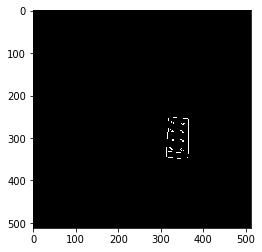

In [42]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import sys
import math
import json
import re
import utils.feature_utils as fu

%matplotlib inline

fu.dim = 512

expr = re.compile("([-]?[0-9]*\.[0-9]{4})")


datadir = "/Users/will/Desktop/brick_oneofeach/"
img0 = cv2.imread('wing2.png',0)
img = cv2.imread(datadir + '2_brick_a.png')


gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)


edged = cv2.Canny(gray, 30, 200)
'''
cv2.imshow('Edges', edged)
if cv2.waitKey(0) & 0xff == 27:
   cv2.destroyAllWindows()
'''
plt.imshow(edged,cmap='gray')
plt.show()

kernel = np.ones((2,2), np.uint8) 
edged = cv2.dilate(edged, kernel, iterations=2) 


#cv2.imshow('Dilated', edged)

'''
if cv2.waitKey(0) & 0xff == 27:
   cv2.destroyAllWindows()
'''

contours, hierarchy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


(9, 3)


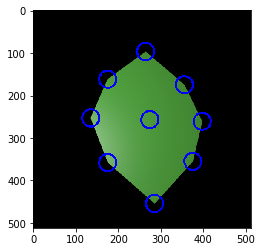

array([[576.25736062,   0.        , 248.52187915],
       [  0.        , 574.53464139, 245.49564366],
       [  0.        ,   0.        ,   1.        ]])

In [61]:
dist_coeffs = np.zeros((9,1))
cammat = np.zeros((3,3))


overts, sverts = fu.getCalibCorrs()
#sverts = fu.toNDC(sverts, (512,512))
#sverts
overts = np.delete(overts, 3, axis=1)
ndc = fu.toNDC(sverts, (512,512))

calibimg = cv2.imread("/Users/will/projects/legoproj/utils/calib_data/calib.png")

for vert in ndc:
    cv2.circle(calibimg, (vert[0], vert[1]), 20, (0, 0, 255), 3)

print(overts.shape)
    
plt.imshow(calibimg)
plt.show()

# calibimg.shape[::-1]
# cameraMatrix = cammat
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([overts.astype('float32')], [ndc.astype('float32')], (512,512), None, None)
mtx


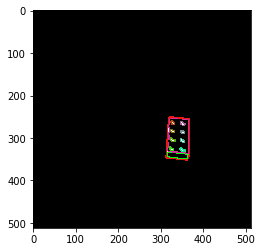

Found contour of length: 119.21320307254791
Found contour of length: 39.31370830535889
Found contour of length: 29.899494647979736
Found contour of length: 29.313708305358887
Found contour of length: 35.3137081861496
Found contour of length: 28.727921724319458
Found contour of length: 27.899494528770447
Found contour of length: 34.72792172431946
Found contour of length: 29.899494767189026
Found contour of length: 265.11269783973694
Found contour of length: 299.11269783973694


In [44]:
img1 = cv2.cvtColor(edged,cv2.COLOR_GRAY2RGB)

num = len(contours)

for i in range(num):
    one = math.floor(i/num * 255)
    other = 255 - one
    b = 150 if i % 2 else 20
    cv2.drawContours(img1, contours, i, (one, other, b), 2)

 
plt.imshow(img1)
plt.show()

for contour in contours:
    perimeter = cv2.arcLength(contour,True)
    print("Found contour of length: " + str(perimeter))

In [45]:
t = contours[-2]
t2 = contours[0]

In [46]:
approx = cv2.approxPolyDP(t,0.05*cv2.arcLength(t,True),True)
approx2 = cv2.approxPolyDP(t2,0.05*cv2.arcLength(t2,True),True)
approx2

array([[[315, 335]],

       [[364, 341]],

       [[360, 349]],

       [[320, 346]]], dtype=int32)

In [47]:
def get_pair(index, points):
    
    num = len(points)
    for i in range(num):
        j = i + 1 if i < num - 1 else 0
        
        if i == index:
            return np.array([points[i], points[j]])
    return None


def get_slopes(points):
    num = len(points)
    slopes = []
    
    for i in range(num):

        j = i + 1 if i < num - 1 else 0
        
        diff = points[j] - points[i]
        
        if diff[1] == 0:
            diff[1] += 1
            
        slope = diff[0]/diff[1]
        slopes.append(tuple([i, slope]))
    
    slopes.sort(key=lambda x: x[1])
    return slopes


def get_parallel_pair(slopes):
    
    num = len(slopes)
    
    for i in range(num):
        j = i + 1 if i < num - 1 else 0
        
        cur0 = slopes[0][1]
        cur1 = slopes[1][1]
        
        if abs(cur1 - cur0) < .5:
            return tuple([cur0[0], cur1[0]])
        
    return None
        
    
    
def edge_march(edge, studs):
    return None
    

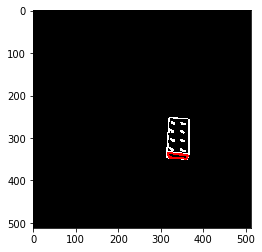

In [48]:
img2 = cv2.cvtColor(edged,cv2.COLOR_GRAY2RGB)
cv2.drawContours(img2, [approx2], 0, (255, 0, 0), 3)

plt.imshow(img2)
plt.show()

In [49]:
approx = np.reshape(approx, (-1,2))

slopes = get_slopes(approx)

approx2 = np.reshape(approx2, (-1,2))
slopes2 = get_slopes(approx2)
approx

array([[322, 253],
       [365, 258],
       [364, 336],
       [315, 329]], dtype=int32)

In [50]:
line = get_pair(1,approx)
print(line)

[[365 258]
 [364 336]]


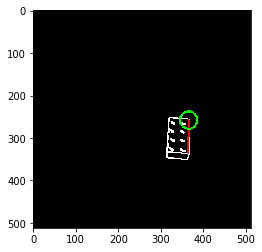

In [51]:
img2 = cv2.cvtColor(edged,cv2.COLOR_GRAY2RGB)
cv2.drawContours(img2, [line], 0, (255, 0, 0), 3)

cv2.circle(img2, (365, 258), 20, (0, 255, 0), 3)

plt.imshow(img2)
plt.show()

In [52]:
ocoordscw = np.array([(-0.64, -0.32, 0.0), (-0.64, 0.32, 0.0), (0.64, 0.32, 0.0),(0.64, 0.32, -0.384)], dtype = "float32")
#ocoordscw = np.array([(-0.64, 0, -0.32), (-0.64, 0, 0.32), (0.64, 0, 0.32), (0.64, 0, -0.32)], dtype = "double")
scoordscw = []

for t in approx[0:4]:
    scoordscw.append(tuple(t))

#scoordscw.append(tuple([360, 349]))  
scoordscw = np.array(scoordscw, dtype = "double")

pmat = fu.get_object_matrices(datadir + "mats/{}.txt".format(2))["Projection"]

f = pmat[0][0]
pmat

array([[ 2.1875,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  2.1875,  0.    ,  0.    ],
       [ 0.    ,  0.    , -1.002 , -0.2002],
       [ 0.    ,  0.    , -1.    ,  0.    ]], dtype=float32)

In [53]:
cmat = np.array([  [f, 0, 256],  [0, f, 256], [0, 0, -1]  ], dtype = "double")

In [54]:
cmat
ocoordscw.shape

(4, 3)

In [62]:
dist_coeffs = np.zeros((4,1))
ocoordscw = np.reshape(ocoordscw, (4,1,3))
scoordscw = np.reshape(scoordscw, (4,1,2))
ocoordscw = ocoordscw.astype(np.float32)
scoordscw = scoordscw.astype(np.float32)

#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(ocoordscw, scoordscw, (512, 512),None,None)
r = cv2.solvePnPRansac(ocoordscw, scoordscw, mtx, dist, flags=(cv2.SOLVEPNP_ITERATIVE))
#mat, jac = cv2.Rodrigues(r[1])
#mat.append([0.0,0.0,0.0,1])
r

(True, array([[ 1.76287171],
        [ 2.00963852],
        [-0.59269336]]), array([[1.34904367],
        [0.67589061],
        [8.36928889]]), array([[0],
        [1],
        [2],
        [3]], dtype=int32))

In [63]:
rvec = r[1]
tvec = r[2]
tvec

array([[1.34904367],
       [0.67589061],
       [8.36928889]])

In [65]:
(pt, jac) = cv2.projectPoints(np.array([(0,0.0,0.0),(1.0, 0.0, 0.0),(0.0, 1.0, 0.0),(0.0, 0.0, 1.0)]), rvec, tvec, mtx, dist)

In [66]:
pt = pt.astype(int)
pt

array([[[342, 292]],

       [[339, 357]],

       [[411, 300]],

       [[353, 254]]])

(339, 357)
(411, 300)
(353, 254)


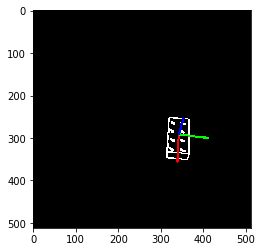

In [67]:
img3 = cv2.cvtColor(edged,cv2.COLOR_GRAY2RGB)
lines = [(255,0,0), (0,255,0), (0,0,255)]
#cv2.circle(img3, tuple(pt[0][0]), 20, (0, 0, 255), 3)

i = 0
for point in pt[1:4]:
    o = pt[0][0]
    print(tuple(point[0]))
    cv2.line(img3, tuple(o), tuple(point[0]), lines[i], 3)
    i+=1
    
plt.imshow(img3)
plt.show()